# Homework 5

##### Data: chall.txt

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 13th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [56]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
import seaborn as sns
%matplotlib inline

## Question 1: We'll Always Have that Night Sampling in Monte Carlo

**Coding required**


Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Inverse Transform Sampling

**1.2.** Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)


<div class="answer-separator">
------------------------
</div>

## Question 2: The Consequences of O-ring Failure can be Painful and Deadly

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(\mathbf{z})$ is defined to be the logistic function -- $f(\mathbf{ z }) = 1/(1 + \exp(\mathbf{ -z }))$ 

**2.2.** Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)

**2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

**2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

**2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

**2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

**2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

> **2.1.** Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior. 

<div class="answer-separator">
------------------------
</div>

## Question 3: Maximum Uniformity -- Frequentist Bootstraps and the Bayesian Posterior

**Coding required**

Recall in HW 3 Question 1 we attempted to explore an edge case in using non-parametric bootstrap to construct confidence intervals.  Let's revisit the setup of that problem.
Suppose you have $\{X_1, X_2, ... X_n\}$ datapoints such that $X_i$ are independently and identically drawn from a $Unif(0, \theta)$.  Consider the extreme order statistic Y = $X_{(n)}$ = max($X_1, X_2, ... X_n$).

<div class="answer-separator">
------------------------
</div>

> **3.1.** Derive (or possibly re-write from HW3) expressions for $F_Y(y\ \vert\ n, \theta)$ the CDF of Y and $f_Y(y\ |\ n, \theta)$ the pdf of Y.

CDF
$$\begin{equation}
\begin{split}
F_Y(y\vert n,\theta) = \Pr \left(X_{(n)} \leq y \vert \theta\right) = \Pr \left(X_1, \dots, X_n \leq y \vert \theta \right) = \prod_{i = 1} ^ n \Pr\left(X_i \leq y \vert \theta \right) \\
=  \begin{cases}
 0 \text{ if } y \leq 0 \\
 \left(\frac{y}{\theta}\right) ^ n \text{ if } 0 < y \leq \theta \\
 1 \text{ if } y \geq \theta
\end{cases}
\end{split}
\end{equation}
$$

PDF

$$ f_Y(Y\vert\theta)  = \frac{d F_Y(Y\vert \theta)}{d Y} = 
\begin{cases}
0 \text{ if } Y \leq 0 \\
n Y^{n-1} / \theta ^ n \text{ if } 0 \leq Y < \theta \\
0 \text{  if } Y \geq \theta
\end{cases}$$

> **3.2.** In HW3 we had difficulty constructing confidence intervals to estimate $\theta$ with percentiles as normal so instead we introduced  pivot confidence intervals.  Let's reframe the problem so that we can use percentiles to construct our confidence intervals.  Define $Z \equiv n \cdot (\theta - Y)$ use elementary calculation to write an expression for $F_Z(z\ \vert\ n, \theta)$ the CDF of $Z$ and $f_Z(y\ |\ n, \theta)$ the pdf of Z.

$$
F_Z(z\ \vert\ n, \theta) = \Pr(Z \leq z \vert n, \theta) = \\
\Pr\left(n \left(\theta - Y\right) \leq z \vert n, \theta \right) = \\
\Pr\left(\theta - \frac{z}{n} \leq Y \vert \theta, \right) = \\
\Pr\left(Y \geq \theta - \frac{z}{n}\right) = \\
1 - \Pr\left(Y < \theta - \frac{z}{n} \right) = \\
1 - \prod_i\Pr\left(X_i < \theta - \frac{z}{n} \right) = \\
=
\begin{align}
\begin{cases}
0 & \text{if }  z \leq 0\\
1 & \text{if } z \geq n \theta \\
1 - \left( 1 - \frac{z}{\theta n}\right)^n & \text{else}  \\
\end{cases}
\end{align}
$$

The pdf is now easy to derive as well:
$$
f_Z(y\vert n, \theta)
=
\begin{align}
\begin{cases}
0 & \text{if } z \leq 0 \text{ or } z \geq n \theta \\
\left(1 - \frac{y}{\theta n}\right)^{n-1}\frac{1}{\theta} & \text{else}
\end{cases}
\end{align} \\
$$

> **3.3.** What is the limiting distribution of Z (as $n \rightarrow \infty$)?  Plot that limiting distribution.

From the expression above, it's clear that this distribuion converges to an **exponential distribution with mean $\theta$** in the limit $n\rightarrow \infty$.

Text(0.5,1,'Limiting distribution is exponential with mean $\\theta=10$')

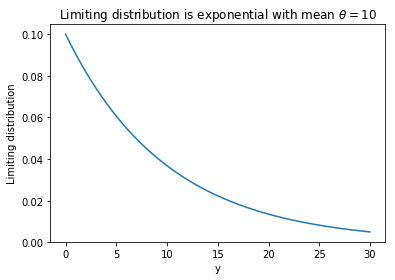

In [43]:
x = np.arange(0, 30, 0.01)
theta = 10
plt.plot(x, scipy.stats.expon.pdf(x, scale=theta))
plt.xlabel("y")
plt.ylabel("Limiting distribution")
plt.title(r"Limiting distribution is exponential with mean $\theta=10$")

> **3.4. Use scipy/numpy to generate 100000 samples {$X_i$} from Unif(0,100) (i.e. let $\theta$ = 100).  Store them in Based on your data sample, what's $\hat{\theta}$ the empirical estimate for $\theta$.**

In [48]:
np.random.seed(1)
theta = 100
n_samples = 1000
uniform_samples = np.random.uniform(high=theta, size=n_samples)
theta_hat = np.max(uniform_samples)
print(r"Empirical estimate for $\theta$ is {:.3f}".format(theta_hat))

Empirical estimate for $\theta$ is 99.732


> **3.5.** Use non-parametric bootstrap to generate a sampling distribution of 10000 estimates for $Z$ by substituting $\hat{\theta}$ for $\theta$.  Plot a histogram of your sampling distribution.  Make sure to title and label the plot.  Use percentiles to construct the 10% and 68% bootstrap confidence intervals.  Plot them in your graph. **Hint:  Should the confidence intervals be symmetric around the estimate $\hat{\theta}$**?


In [62]:
n_bootstraps = 1000
Z_bootstrapped = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    resampled = np.random.choice(uniform_samples, replace=True, size=n_samples)
    theta_hat_resampled = np.max(resampled)
    Z_bootstrapped[i] = n_samples * (theta_hat - theta_hat_resampled)

In [64]:
np.percentile(Z_bootstrapped, q=[10, 68])

array([ 0.        , 56.94252433])

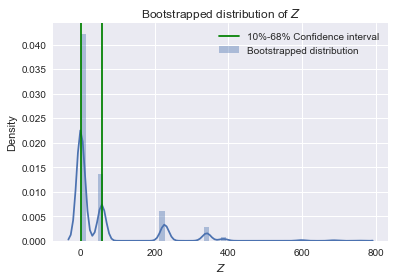

In [80]:
sns.distplot(Z_bootstrapped, label='Bootstrapped distribution')
plt.axvline(np.percentile(Z_bootstrapped, q=10), c='green', label='10%-68% Confidence interval')
plt.axvline(np.percentile(Z_bootstrapped, q=68), c='green')
plt.title(r"Bootstrapped distribution of $Z$")
plt.xlabel(r"$Z$")
plt.ylabel("Density")
plt.legend()

> **3.6.** Make an argument that we can construct a bootstrap confidence interval that always mismatches the limiting distribution.

> **1.8.** Let's switch to being Bayesian.  In 1.1 we came up with an expression for the likelihood $f_Y(y\ |\ n, \theta)$.  Use the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) to construct a prior for $\theta$.  What are some reasonable values to use for the scale and shape?

From the linked Wikipedia article above, the CDF of the Pareto distribution is

$$
F_X(x\vert \alpha, x_m) =
\begin{align}
\begin{cases}
1 - \left(\frac{x_m}{x}\right)^\alpha & x \geq x_m\\
0 & x < x_m
\end{cases}
\end{align}
$$

Correspondingly, the likelihood is

$$
f_X(x\vert \alpha, x_m) =
\begin{align}
\begin{cases}
\frac{\alpha x_m^{\alpha}}{x^{\alpha + 1}} & x \geq x_m\\
0 & x < x_m
\end{cases}
\end{align}
$$

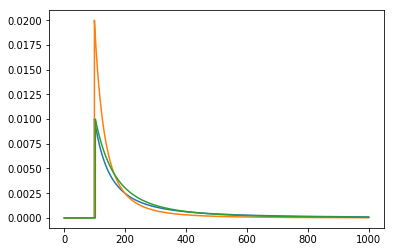

In [65]:
x = np.arange(0, 1000,0.1)
plt.plot(x, scipy.stats.pareto.pdf(x, loc=-1, b=1, scale=100))
plt.plot(x, scipy.stats.pareto.pdf(x, loc=-1, b=2, scale=100))
plt.plot(x, scipy.stats.pareto.pdf(x, loc=-98, b=2, scale=200))

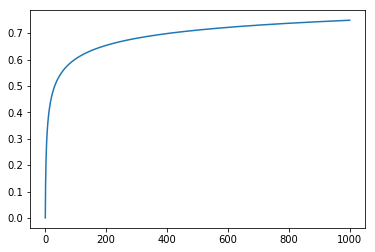

In [38]:
plt.plot(x, scipy.stats.pareto.cdf(x, loc=-1, b=.2))

> **1.9.** Write down an expression for the posterior distribution $f_Y(\theta\ |\ n, y)$ 

> **1.10.** Draw 10000 posterior samples and plot a histogram of the posterior distribution.  Use percentiles to construct the 68% HPD.  Plot the posterior distribution and mark the HPD on your plot.

> **1.11.** How does th 68% HPD compare with the confidence interval generated from bootstrapping?  Why doesn't the bayesian interval construction suffer the same concerns you noted in 1.6